# Thực hành về nhà: Mô hình sinh DCGAN

In [1]:



import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import glob
import cv2
import torch.nn.functional as F
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms

from torch.nn import CrossEntropyLoss, Dropout, Softmax, Linear, Conv2d, LayerNorm
import matplotlib.pyplot as plt
from torchsummary import summary

In [2]:
width = 28
height = 28
channels = 1

<H2>1. Load dữ liệu MNIST</H2>


In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))])

batch_size = 32

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

100%|██████████| 9.91M/9.91M [00:00<00:00, 45.2MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.59MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 13.5MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.94MB/s]


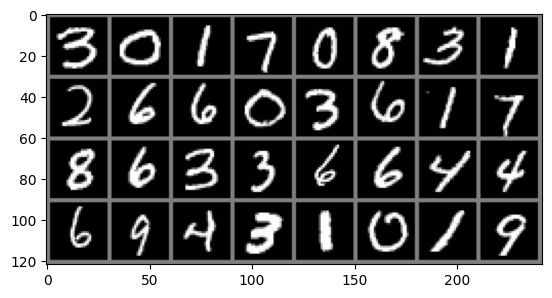

    3     0     1     7     0     8     3     1     2     6     6     0     3     6     1     7     8     6     3     3     6     6     4     4     6     9     4     3     1     0     1     9


In [4]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % labels[j].item() for j in range(batch_size)))

<H2>2. Generator</H2>

Lập trình mạng generator. 
    
    + Đầu vào là vector ngẫu nhiên 100 chiều.
    + Đầu ra là một ảnh fake với giá trị pixel trong khoảng [-1, 1].

Các thông số của mạng như sau

- Dense(7*7*128, kernel_initializer='glorot_normal',input_shape=(inidim,)))
- LeakyReLU(0.2))
- Reshape( [7, 7, 128])
- UpSampling2D(size=(2, 2))
- Conv2D(64, (5, 5), padding='same', kernel_initializer='glorot_uniform')
- LeakyReLU(0.2)
- UpSampling2D(size=(2, 2))
- Conv2D(1, (5, 5), padding='same', kernel_initializer='glorot_uniform'))
- Activation('tanh')



In [5]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.init_size = 7
        self.l1 = nn.Sequential(
            nn.Linear(100, 128 * self.init_size ** 2),
            nn.LeakyReLU(0.2),
        )

        self.conv_blocks = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 5, padding='same'),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(64, 1, 5, padding='same'),
            nn.Tanh(),
        )

    def forward(self, z):
        out = self.l1(z)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img


G = Generator().cuda()
summary(G, (100, ), batch_size=-1, device='cuda')
print("_____________________ Generator Created_____________________")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 6272]         633,472
         LeakyReLU-2                 [-1, 6272]               0
          Upsample-3          [-1, 128, 14, 14]               0
            Conv2d-4           [-1, 64, 14, 14]         204,864
         LeakyReLU-5           [-1, 64, 14, 14]               0
          Upsample-6           [-1, 64, 28, 28]               0
            Conv2d-7            [-1, 1, 28, 28]           1,601
              Tanh-8            [-1, 1, 28, 28]               0
Total params: 839,937
Trainable params: 839,937
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.87
Params size (MB): 3.20
Estimated Total Size (MB): 4.08
----------------------------------------------------------------
_____________________ Generator Created___

<H2>4. Discriminator</H2>

Khai báo mạng discriminator

    + Đầu vào là một ảnh 28x28
    + Đầu ra là một xác suất cho ta biết ảnh đấy là real hay fake với giá trị trong miền [0, 1]

Thông số của mạng như sau:

-  Conv2D(64, (5, 5), strides=(2, 2), padding= 'same',input_shape=shp)
-  LeakyReLU(0.2)
-  Dropout(dropout_rate)
-  Conv2D(128, (5, 5), strides=(2, 2), padding = 'same')
-  LeakyReLU(0.2)
-  Dropout(dropout_rate)
-  Flatten()
-  Dense(1,activation='sigmoid')

In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(1, 64, 5, stride=2, padding=2),
            nn.LeakyReLU(0.2),
            nn.Dropout2d(0.3),
            nn.Conv2d(64, 128, 5, stride=2, padding=2),
            nn.LeakyReLU(0.2),
            nn.Dropout2d(0.3),
            nn.Flatten(),
        )

        # The height and width of downsampled image
        ds_size = 28 // (2 ** 2)
        self.adv_layer = nn.Sequential(nn.Linear(128 * (ds_size ** 2), 1), nn.Sigmoid())

    def forward(self, img):
        out = self.model(img)
        out = out.view(out.shape[0], -1)
        validity = self.adv_layer(out)

        return validity

D = Discriminator().cuda()
summary(D, (1, 28, 28), batch_size=-1, device='cuda')
print("____________________ Discriminator Created____________________")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 14, 14]           1,664
         LeakyReLU-2           [-1, 64, 14, 14]               0
         Dropout2d-3           [-1, 64, 14, 14]               0
            Conv2d-4            [-1, 128, 7, 7]         204,928
         LeakyReLU-5            [-1, 128, 7, 7]               0
         Dropout2d-6            [-1, 128, 7, 7]               0
           Flatten-7                 [-1, 6272]               0
            Linear-8                    [-1, 1]           6,273
           Sigmoid-9                    [-1, 1]               0
Total params: 212,865
Trainable params: 212,865
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.48
Params size (MB): 0.81
Estimated Total Size (MB): 1.29
-------------------------------------------

<h2>5. GAN model</h2>

Chúng ta ghép hai mạng vào với nhau mang generator trước, mạng disciminator sau

Lập trình hàm để ghép mạng

In [7]:
optimizer_G = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999), weight_decay=8e-8)
optimizer_D = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999), weight_decay=8e-8)

epochs        = 1000
adversarial_loss = nn.BCELoss().cuda()


losses_G = []
losses_D = []
samples = []

In [8]:
for epoch in range(epochs):
    for (i, (imgs, _)) in enumerate(trainloader, start=1):
        # Adversarial ground truths
        valid = Variable(torch.cuda.FloatTensor(imgs.size(0), 1).fill_(1.0), requires_grad=False)
        fake = Variable(torch.cuda.FloatTensor(imgs.size(0), 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(torch.cuda.FloatTensor))

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample noise as generator input
        z = Variable(torch.cuda.FloatTensor(np.random.normal(0, 1, (imgs.shape[0], 100))))

        # Generate a batch of images
        gen_imgs = G(z)

        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(D(gen_imgs), valid)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(D(real_imgs), valid)
        fake_loss = adversarial_loss(D(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        if epoch % 10 == 0 and i == len(trainloader):
            print(
                "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
                % (epoch, epochs, i, len(trainloader), d_loss.item(), g_loss.item())
            )
            
            losses_G.append(g_loss.item())
            losses_D.append(d_loss.item())
            samples.append(gen_imgs)


/tmp/ipykernel_81/130941389.py:4: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at /pytorch/torch/csrc/tensor/python_tensor.cpp:78.)
  valid = Variable(torch.cuda.FloatTensor(imgs.size(0), 1).fill_(1.0), requires_grad=False)


[Epoch 0/1000] [Batch 1875/1875] [D loss: 0.000058] [G loss: 10.453324]
[Epoch 10/1000] [Batch 1875/1875] [D loss: 0.616252] [G loss: 1.062219]
[Epoch 20/1000] [Batch 1875/1875] [D loss: 0.563823] [G loss: 0.905607]
[Epoch 30/1000] [Batch 1875/1875] [D loss: 0.518939] [G loss: 1.219557]


KeyboardInterrupt: 

### Vẽ đồ thị loss khi huấn luyện

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(list(range(len(losses_G)/10)*10), losses_G, label="G_loss")
plt.plot(list(range(len(losses_D)/10)*10), losses_D, label="D_loss")
plt.title("Training losses", fontsize=16)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Losses", fontsize=14)
plt.legend(loc="upper right", fontsize=14)
plt.show()

### Trực quan dữ liệu sinh ra thử mạng học được

In [ ]:
i = 0
for i in range(0, len(samples), 10):
    images = samples[i].data.cpu().numpy()
    print("    ____________________ Step = %d ____________________" % i)
    plt.figure(figsize=(6, 6))
    for i in range(16):
        plt.subplot(4, 4, i+1)
        image = images[i, :, :, :]
        image = np.reshape(image, [height, width])
        plt.imshow(image, cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    print("\n")